In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras, config
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [17]:
def TrainData():
    fake_img = r"archive\train\FAKE"
    real_img = r"archive\train\REAL"
    image = []
    label = []

    random_fake = np.random.choice(os.listdir(fake_img), 40000, replace=False)
    random_real = np.random.choice(os.listdir(real_img), 40000, replace=False)

    # Set 0 to represent fake, and 1 to represent real
    for path in tqdm(random_fake, desc='Fake Training Data'):
        data = cv2.imread(os.path.join(fake_img, path))
        image.append(data)
        label.append(0)

    for path in tqdm(random_real, desc='Real Training Data'):
        data = cv2.imread(os.path.join(real_img, path))
        image.append(data)
        label.append(1)

    print()
    # image augmantation
    image = np.array(image).reshape(-1, 32, 32, 3)
    label = np.array(label)
    gen_image = []
    gen_label = []
    gen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip = True,
    )
    gen.fit(image)

    for i, j in gen.flow(image, label, batch_size=200):
        gen_image.append(i)
        gen_label.append(j)
        if len(gen_image)%50==0:
            print(f'{len(gen_image)*200}/80000 augmented data generated.')
        if len(gen_image)==400:
            print('Data augmentation done')
            break
    image = np.concatenate(gen_image)
    label = np.array(gen_label).flatten()

    image = np.array(image).reshape(-1, 32, 32, 3)
    label = np.array(label)
    image = image/255.0

    state = np.random.get_state()
    np.random.shuffle(image)
    np.random.set_state(state)
    np.random.shuffle(label)
    print('\nShuffle training data done.\n')
    print(f'Total training data : {len(image)}')
    
    return image, label

In [3]:
def TestData():
    fake_path = r"archive\test\FAKE"
    real_path = r"archive\test\REAL"
    image = []
    label = []
    # Set 0 to represent fake, and 1 to represent real
    for path in tqdm(os.listdir(fake_path), desc='Fake Testing Data'):
        data = cv2.imread(os.path.join(fake_path, path))
        image.append(data)
        label.append(0)
    
    for path in tqdm(os.listdir(real_path), desc='Real Testing Data'):
        data = cv2.imread(os.path.join(real_path, path))
        image.append(data)
        label.append(1)

    image=np.array(image).reshape(-1, 32, 32, 3)
    image=image/255
    label=np.array(label)

    return image, label

In [30]:
def CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [19]:
train_x, train_y = TrainData()

Real Training Data: 100%|██████████| 40000/40000 [00:08<00:00, 4620.61it/s]



10000/80000 augmented data generated.
20000/80000 augmented data generated.
30000/80000 augmented data generated.
40000/80000 augmented data generated.
50000/80000 augmented data generated.
60000/80000 augmented data generated.
70000/80000 augmented data generated.
80000/80000 augmented data generated.
Data augmentation done

Shuffle training data done.

Total training data : 80000


In [20]:
test_x, test_y = TestData()

Real Testing Data: 100%|██████████| 10000/10000 [00:22<00:00, 448.27it/s]


In [7]:
# """
# Tensorflow supports running computations on GPU 

# WARNING : You need to have CUDA, cuDNN, and tensorflow with version lower than 2.11.0, 
#           if not, DON'T execute this cell.
# """
# physical_devices = config.list_physical_devices('GPU')
# config.experimental.set_memory_growth(physical_devices[0], True)
# print('Running on GPU available now')

In [31]:
model = CNN()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 2304)              0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [32]:
train_ac, train_loss = [], []
test_ac, test_loss = [], []

for epoch in range(1, 21):
    history = model.fit(train_x, train_y, epochs=1, batch_size=200)
    loss, ac = model.evaluate(test_x, test_y, batch_size=200)

    train_loss.append(history.history['loss'])
    train_ac.append(history.history['accuracy'])
    test_loss.append(loss)
    test_ac.append(ac)
    # prediction = model.predict(test_x)
    # prediction = [int(np.round(prediction[p])) for p in range(len(prediction))]
    # ac2=0
    # for i, j in zip(test_y, prediction):
    #     if i==j:
    #         ac2+=1
    # print(ac, ac2/len(prediction), end=' ')
    print()

100/100 [==============================] - 2s 17ms/step - loss: 0.4655 - accuracy: 0.7911

100/100 [==============================] - 2s 17ms/step - loss: 0.5327 - accuracy: 0.7778

100/100 [==============================] - 2s 17ms/step - loss: 0.5532 - accuracy: 0.7699

100/100 [==============================] - 2s 17ms/step - loss: 0.4973 - accuracy: 0.7898

100/100 [==============================] - 2s 17ms/step - loss: 0.4734 - accuracy: 0.8106

100/100 [==============================] - 2s 18ms/step - loss: 0.5284 - accuracy: 0.8006

100/100 [==============================] - 2s 17ms/step - loss: 0.5279 - accuracy: 0.7918

100/100 [==============================] - 2s 17ms/step - loss: 0.5783 - accuracy: 0.7814

100/100 [==============================] - 2s 17ms/step - loss: 0.4584 - accuracy: 0.8220

100/100 [==============================] - 2s 18ms/step - loss: 0.4688 - accuracy: 0.8187



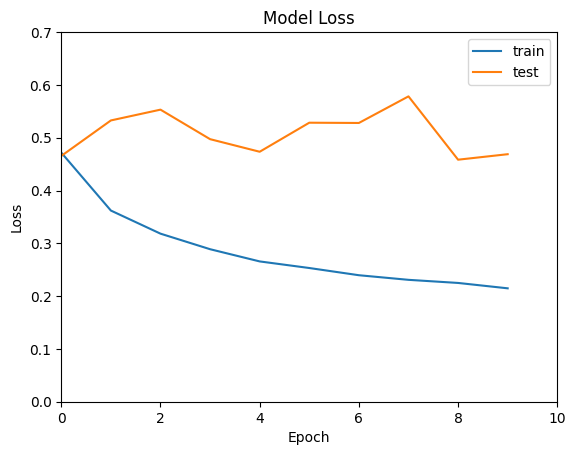

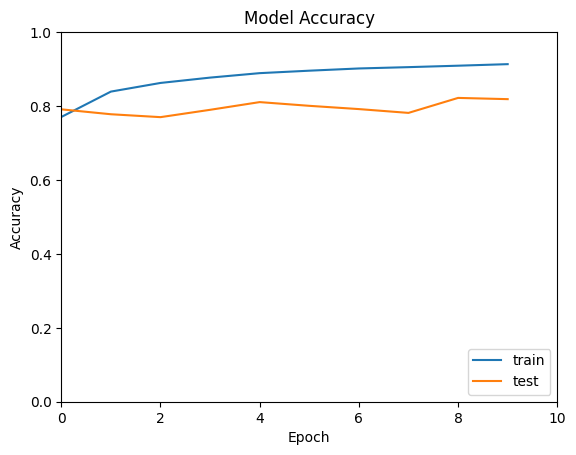

In [36]:
# Plot the loss and accuracy of training set.
plt.plot(train_loss)
plt.plot(test_loss)
plt.axis([0, 10, 0, 0.7])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(train_ac)
plt.plot(test_ac)
plt.axis([0, 10, 0, 1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()